In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.relu import UnaryReLU
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
rng = "Sobol"
encode = "RC"

# rng = "Race"
# encode = "TC"

in_dim = 1024

mode = "bipolar"
bitwidth = 8
buf_dep = 8
sr = False
stype = torch.float
btype = torch.float
rtype = torch.float

uReLU = UnaryReLU(depth=buf_dep, bitwidth=bitwidth, encode=encode, shiftreg=sr, stype=stype, btype=btype).to(device)

iVec = (((torch.rand(in_dim)*2-1)*(2**bitwidth)).round()/(2**bitwidth)).to(device)
start_time = time.time()
oVec = torch.nn.ReLU()(iVec)
print("--- %s seconds ---" % (((time.time() - start_time))*2**bitwidth))

print("input", iVec)
print("real output", oVec)
        
iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

iVecRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range((2**bitwidth)):
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)

        oVecU = uReLU(iBS)
        oVecPE.Monitor(oVecU)
#         print(i)
#         print("in bs       ", iBS)
#         print("internal acc", uReLU.acc.data)
#         print("out bs      ", oVecU)

    print("--- %s seconds ---" % (time.time() - start_time))
    print("final input error: ", min(iVecPE()[1]), max(iVecPE()[1]))
    print("final output error:", min(oVecPE()[1]), max(oVecPE()[1]))
    print("final output pp:", oVecPE()[0].data)
    print("final output pe:", oVecPE()[1].data)
    
    result_pe = oVecPE()[1].cpu().numpy()

--- 0.25616455078125 seconds ---
input tensor([ 0.9648, -0.7500,  0.1641,  ...,  0.3359, -0.8281, -0.0117],
       device='cuda:0')
real output tensor([0.9648, 0.0000, 0.1641,  ..., 0.3359, 0.0000, 0.0000], device='cuda:0')
--- 0.22499966621398926 seconds ---
final input error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
final output error: tensor(-0.0039, device='cuda:0') tensor(0.0078, device='cuda:0')
final output pp: tensor([0.9688, 0.0078, 0.1641,  ..., 0.3359, 0.0078, 0.0078], device='cuda:0')
final output pe: tensor([0.0039, 0.0078, 0.0000,  ..., 0.0000, 0.0078, 0.0078], device='cuda:0')


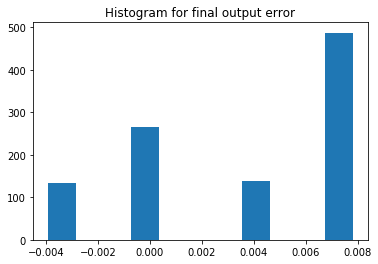

In [5]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()